## Using AFESim as an audio transform
Rockpool contains a simulation of Audio Front End (AFE) of XyloAudio 3, which is used as pre-processing step to convert audio signals to spike trains. The converted version of audio can be used in the following scenarios:
- As training sample to train a SNN model in Rockpool

- As test sample to test a model on the SNN Core of XyloAudio 3 HDK. This is a simplified test on HDK that can be used with debug purposes, by bypassing the microphone and AFE in the HDK. This type of test has been described in (link to the tutrorail)

In this tutorial we will refer to the simulator of AFE in XyloAudio 3 as AFESim3 and will go through an example on how to configure and use AFESim3 as an audio transform for a train or test pipeline. 

 AFESim3 module in Rockpool can be used in following operation modes:


- `AFESimExternal`

    - This mode of AFESim3 is independent from the microphone type. It bypasses the microphone path and passes an external audio (14-bit QUANTIZED signal) into filterbank and devisive normalization module

- `AFESimPDM`

    - In this mode audio samples are passed through a pre-processing chain composed of PDM microphone model, filter bank and devisive normalization module
    

## AFESimExternal

As illustrated in the diagram `AFESimExternal` recives an input audio as an array, resamples and quantizes it to 14 bit format and passes it to the filterbank (covering 16 frequency bands between 50 Hz and 17 KHz).


Depending on the selected mode for `spike_gen_mode` fixed of adaptive thresholds will be applied to filter Output channels to generate spike train. `spike_gen_mode` is by default set to `divisive_norm` and changing it and related parameters (`low_pass_averaging_window` , `rate_scale_factor`, `dn_EPS`) is not recomended.

The role of Devisive Normalization (DN) module is to regulate the noise senstivity of different frequency bonds of filterbank, by applying adaptive thresholds. If average power of a filter in certain time window is less than $\epsilon$, the threshold of that filter will be adapted in a way to generate less spikes. 
Only for debug purposes the user may deactivate Devisive Normalization by choosing `spike_gen_mode = 'threshold'` and passing `fixed_threshold_vec`. 

The spike train is rastered with a given `dt` (time step of the SNN model) and passes to `Xylo SNN Core`


    

In [1]:
import warnings
from IPython.display import Image

warnings.filterwarnings("ignore")
Image("figures/afesim_external.png")

Image("figures/afesim_pdm.png")
Following transform can be used to convert `audio: np.ndarray` samples to spike trains. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Union, Optional, Tuple
from rockpool.devices.xylo.syns65302 import AFESimExternal
from dataclasses import dataclass

@dataclass
class AFESim3_external:
    fs: float = 16000
    spike_gen_mode: str = None
    fixed_threshold: Optional[Union[int, Tuple[int]]] = None
    dn_EPS: Optional[Union[int, Tuple[int]]] = 32
    rate_scale_factor: (Optional[int]) = 63
    low_pass_averaging_window: float = 0.084
    dt: float = 0.01

    """
    Args:
        spike_gen_mode (str): The spike generation mode of the AFE. There are two ways to generate spikes, "divisive_norm" and "threshold".
        fixed_threshold_vec (Optional[Union[int, Tuple[int]]]): Used only when `spike_gen_mode = "threshold"`.

        dn_EPS (Optional[Union[int, Tuple[int]]]): Used only when `spike_gen_mode = "divisive_norm"`. Lower bound on spike generation threshold.
        Using this parameter we can control the noise level in the sense that if average power in a channel is less than EPS, the spike rate of that channel is somehow diminished during spike generation.

        rate_scale_factor (Optional[int]): Target `rate_scale_factor` for the `DivisiveNormalization` module. Defaults to 63.
        
        low_pass_averaging_window (Optional[float], optional): Target `low_pass_averaging_window` for the `DivisiveNormalization` module. Defaults to 84e-3.
        dt(float): simulation time step, this needs to match to the dt of snn model 

    """

    def __post_init__(self) -> None:
        if self.spike_gen_mode == "threshold":
            self.fixed_threshold_vec = [self.fixed_threshold for i in range(16)]
            self.dn_inits = {'spike_gen_mode':self.spike_gen_mode,'fixed_threshold_vec':self.fixed_threshold}    
        else:     
            self.fixed_threshold_vec = None
            self.dn_inits = {'spike_gen_mode':self.spike_gen_mode,'fixed_threshold_vec':self.fixed_threshold, 'dn_EPS': self.dn_EPS, 'rate_scale_factor': self.rate_scale_factor,
            'low_pass_averaging_window':self.low_pass_averaging_window}    

        self.afesim3 = AFESimExternal.from_specification(**self.dn_inits, dt = self.dt)

    def __call__(self,audio: np.ndarray) -> np.ndarray:
       
        out,_,_ = self.afesim3((audio, self.fs))
        
        return out.T

from samna.xyloA3.configuration import InputInterfaceConfig


## AFESimPDM
As illustrated in the diagram below, the difference between `AFESimPDM` and `AFESimExternal` is the added digital microphone model composed of sigma delta modulator and polyphase lowpass filter. 

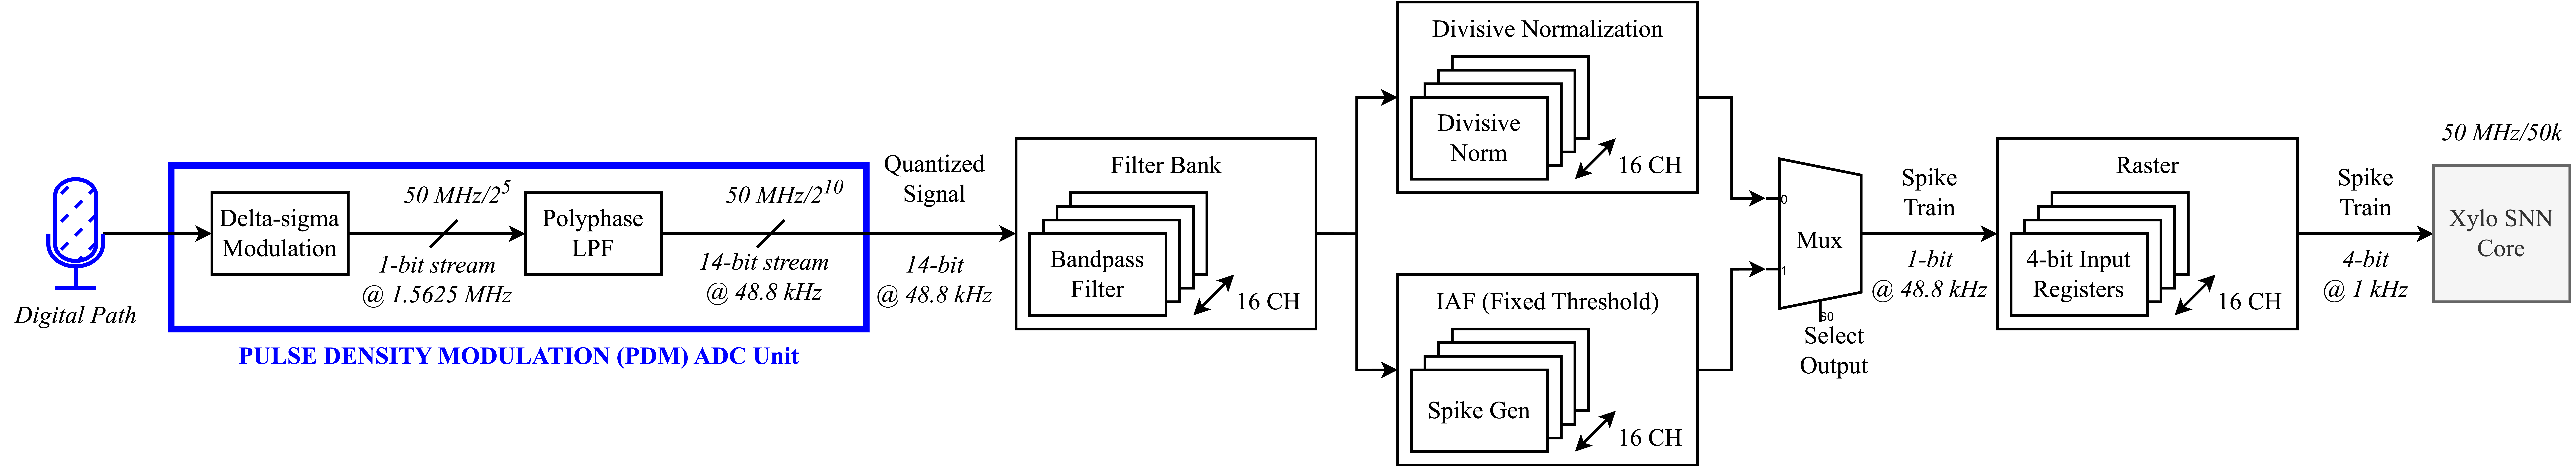

In [3]:
Image("figures/afesimpdm.png")

Following transform can be used to convert `audio: np.ndarray` samples to spike trains. 

In [4]:

from rockpool.devices.xylo.syns65302 import AFESimPDM

@dataclass
class AFESimPDM_transform_output:

    spike_gen_mode: str = None
    fixed_threshold: Optional[Union[int, Tuple[int]]] = None
    dn_EPS: Optional[Union[int, Tuple[int]]] = 32
    rate_scale_factor: (Optional[int]) = 63
    low_pass_averaging_window: float = 0.084
    dt: float = 0.01
    fs: float = 16000

    """
    Args:
        spike_gen_mode (str): The spike generation mode of the AFE. There are two ways to generate spikes, "divisive_norm" and "threshold".
        fixed_threshold_vec (Optional[Union[int, Tuple[int]]]): Used only when `spike_gen_mode = "threshold"`.

        dn_EPS (Optional[Union[int, Tuple[int]]]): Used only when `spike_gen_mode = "divisive_norm"`. Lower bound on spike generation threshold.
        Using this parameter we can control the noise level in the sense that if average power in a channel is less than EPS, the spike rate of that channel is somehow diminished during spike generation.

        rate_scale_factor (Optional[int]): Target `rate_scale_factor` for the `DivisiveNormalization` module. Defaults to 63.
        
        low_pass_averaging_window (Optional[float], optional): Target `low_pass_averaging_window` for the `DivisiveNormalization` module. Defaults to 84e-3.
        dt(float): simulation time step, this needs to match to the dt of snn model 
        fs (float): sampling frequency of audio samples
    """
   
    def __post_init__(self) -> None:

        if self.spike_gen_mode == "threshold":
            self.fixed_threshold_vec = [self.fixed_threshold for i in range(16)]
            self.dn_inits = {'spike_gen_mode':self.spike_gen_mode,'fixed_threshold_vec':self.fixed_threshold}    
        else:     
            self.fixed_threshold_vec = None
            self.dn_inits = {'spike_gen_mode':self.spike_gen_mode,'fixed_threshold_vec':self.fixed_threshold, 'dn_EPS': self.dn_EPS, 'rate_scale_factor': self.rate_scale_factor,
            'low_pass_averaging_window':self.low_pass_averaging_window}    


        self.afesimPDM = AFESimPDM.from_specification(**self.dn_inits,  dt = self.dt)
    def __call__(self,audio: np.ndarray) -> np.ndarray:
       
        out,_,_ = self.afesimPDM((audio, self.fs))
        return out.T     

## To apply AFESim3 transforms
- we apply a test adio (a 1 second baby cry sample) to both introduced AFESim3 transforms

In [5]:
import librosa
# audio_path = 'test_audio/sample_0__basic_length=3_db0=-0.wav'
audio_path = 'test_audio/sample_4__basic_length=1_db0=-0.wav'

test_sample, sr = librosa.load(audio_path, sr= None)
test_sample = np.expand_dims(test_sample, axis = 0)[0]

In [6]:
# afe_ext = AFESim3_external(spike_gen_mode='divisive_norm', dt = 0.001004)
afe_ext = AFESim3_external(spike_gen_mode='divisive_norm', dt = 0.009994)

out_external = afe_ext(test_sample)
afe_pdm = AFESimPDM_transform_output(spike_gen_mode='divisive_norm', dt = 0.009994)
out_pdm = afe_pdm(test_sample)


Text(0.5, 1.0, 'test audio transfomed by AFESimPDM')

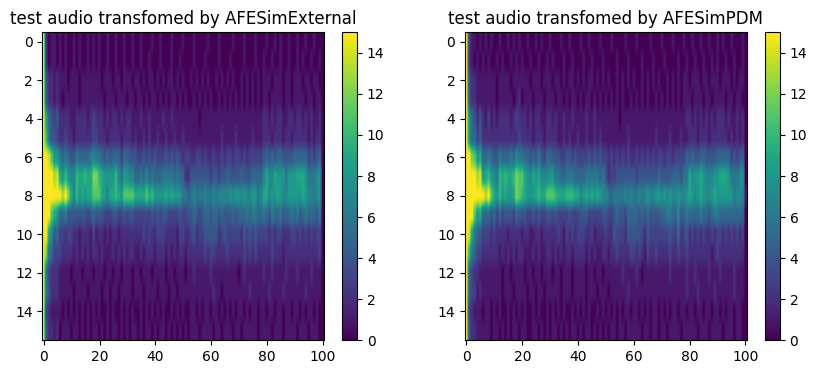

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121); plt.imshow(out_external, aspect='auto'); plt.colorbar(); plt.title('test audio transfomed by AFESimExternal')
plt.subplot(122); plt.imshow(out_pdm, aspect='auto'); plt.colorbar(); plt.title(('test audio transfomed by AFESimPDM'))

In [8]:
np.save('AFESimExternalSample', out_external.T)

The output spike train has dimenstion of $(16, N_{steps})$ where 16 is number of out channels and $ N_{steps}$ is the duration of audio in second devided by proided `dt` of the model.